![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)


# Model-Specific Interpretation with Grad-CAM

In this Notebook, we will demonstrate how to use Grad-CAM, a gradient-based pixel attribution method, to understand which parts of the image the model considers more relevant when making its prediction. We will be using the pre-trained ResNet-50 and play around with various images

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/Juelich-2024/xai-for-cnn/Tutorial_Grad-CAM_for_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-for-cnn

### Imports

Let's start with importing all required Python packages.

In [1]:
# Installing the necessary packages
import utils
import numpy as np
import cv2 as cv

import torch
import matplotlib.pyplot as plt

# add Grad-CAM model to path
import sys  
sys.path.append('../data_and_models/')
from model_gradcam import GradCamModel

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

--------

## Grad-CAM

Before starting with the hands-on part, we prepared a small video summarizing the concepts that will be useful for the rest of the session. Take some time to watch our [Introduction to Grad-CAM](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/Grad-CAM.html).

### Loading and preparing the input image

We need to perform the following steps to have the input image ready to be fed to the model:

* Load the image
* Convert the image to RGB channel
* Transform the image:
  * Convert to PIL format
  * Resize to lower resolution
  * Convert to tensor dtype
  * Normalize the pixel values
* Unsqueeze the image to add a batch dimension


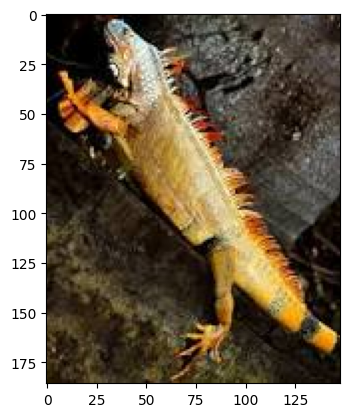

Transformed image size:  torch.Size([1, 3, 224, 224])


In [3]:
# read and visualize the image
path_to_img = '../data_and_models/images/Iguana.jpeg'
img = utils.read_img(path_to_img)
plt.imshow(img)
plt.show()

# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# next transform the so it is ready to be given to the model
trans_img = utils.transform_img(img, mean, std)
print('Transformed image size: ', trans_img.size())

### Loading a Grad-Cam model

For this tutorial, we will use the GradCamModel class, which includes a pretrained ResNet-50 model and functions for returning the feature map activations and gradients. If you are interested, you will find this class in ```gradcam_model.py```.

Let's start loading the model:

In [4]:
# init the GradCamModel
gcmodel = GradCamModel()

# set the evaluation mode
_ = gcmodel.eval()

### Forward pass

After instantiating GradCamModel, we make a forward pass through the network and see what the ResNet-50 predicts. 

In [5]:
# forward pass
out = gcmodel(trans_img) 
pred = out.argmax(dim=1)

print('Classification result:', pred.item())

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Classification result: 39


Click [this link](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) to identify the class name and see if the prediction is correct. 

Now that we verified that our model correctly classifies the iguana, we are going to do the back-propagation with the logit of the predicted class in the ImageNet dataset.

Grad-CAM uses the feature maps produced by the last convolutional layer of a CNN. The authors of Grad-CAM argue, _“we can expect the last convolutional layers to have the best compromise between high-level semantics and detailed spatial information.”_

Grad-CAM is applied to a neural network that has finished training. The weights of the neural network are fixed. We feed an image into the network to calculate the Grad-CAM heatmap for a specific image and a chosen class of interest.

### Grad-CAM Details

Let us assume $y^c$ is the score for class $c$ i.e., the output for class $c$ before the softmax.

**Step 1: Computing Gradient**

Compute the gradient of $y^c$ with respect to the feature map activation $A^k$ of a convolution layer i.e., $\frac {∂y^c}{∂A^k}$

**Step 2: Calculate Global Average Pooling (GAP) of the feature map.**
     
Global average pool the gradients over the width dimension (indexed by $i$) and the height dimension (indexed by $j$) to obtain weights ${\alpha_k^c}$

  $
  {\alpha_k^c} = \frac {1}{Z} \sum_{i} \sum_{j} \frac {∂y^c}{∂A^k_{ij}}
  $

**Step 3: Calculate Final Grad-CAM Localization Map**
     
Perform a weighted combination of the feature map activations $A^k$ where the weights are the ${\alpha_k^c}$ we just calculated and keep only positive contributions applying a ReLU function.

  $
  L^c_{Grad-CAM} = ReLU (\sum_k {\alpha_k^c} A^k)
  $

In [6]:
def calculate_localization_map(gcmodel, img, out, c):

    # Step 1 - Gradient output y wrt. to activation map
    # get the gradient of the output with respect to the parameters of the model
    out[:,c].backward(retain_graph=True)
    # pull the gradients out of the model
    gradients = gcmodel.get_gradient()

    # Step 2 - Global average pooling
    # pool the gradients across the channels
    pooled_gradients = # ADD YOUR CODE HERE

    # Step 3 - Weighted combination of influence and feature maps
    # get the activations of the last convolutional layer
    activations = gcmodel.get_activations(img).detach()
    # weight the channels by corresponding gradients
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
    # average the channels of the activations
    localization_map = torch.sum(activations, dim=1).squeeze()
    # convert the map to be a numpy array
    localization_map = localization_map.numpy()
    # relu on top of the localization map
    localization_map = # ADD YOUR CODE HERE

    return localization_map

def convert_to_heatmap(localization_map, img):
    # normalize the localization_map
    localization_map /= np.max(localization_map)
    # resize to image size
    heatmap = cv.resize(localization_map, (img.shape[1], img.shape[0]))
    # normalize to [0, 255] range and convert to unsigned int
    heatmap = np.uint8(255 * heatmap)
    return heatmap

### Heatmap

Call calculate_heatmap to get the Res-Net GradCAM output for class 'iguana'

Next, process the result for visualisation and visualise it along with the original image and the Grad-CAM heat-map projected onto the original image.

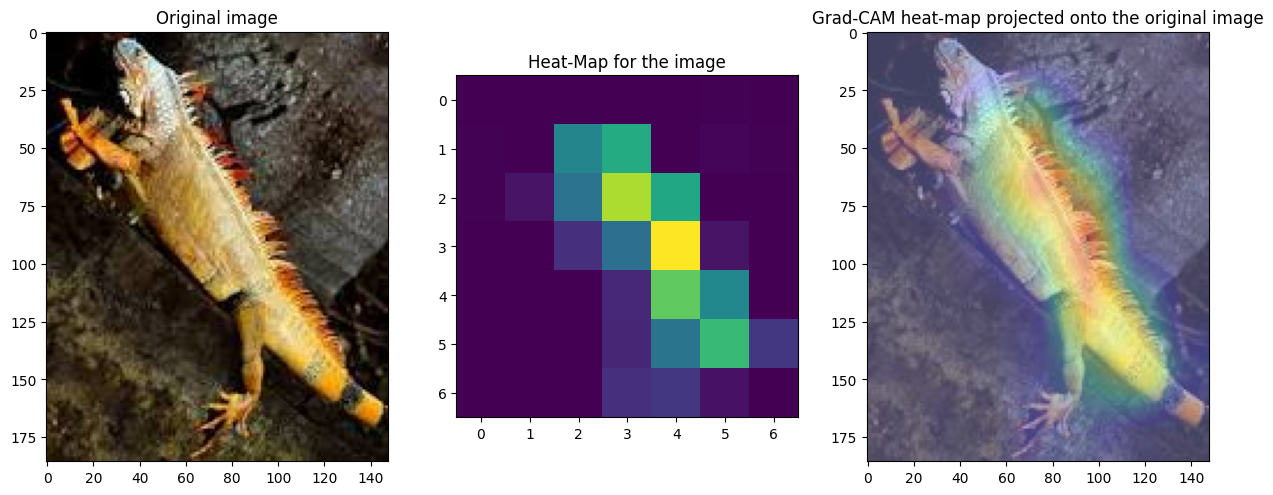

In [7]:
localization_map = calculate_localization_map(gcmodel, trans_img, out, c=pred.item())

heatmap = convert_to_heatmap(localization_map, img)

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img)
plt.title('Original image')
plt.subplot(132)
plt.imshow(localization_map.squeeze())
plt.title('Heat-Map for the image')
plt.subplot(133)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.imshow(img, alpha=0.5)
plt.title('Grad-CAM heat-map projected onto the original image')
plt.show()

### Now let's look at a different image

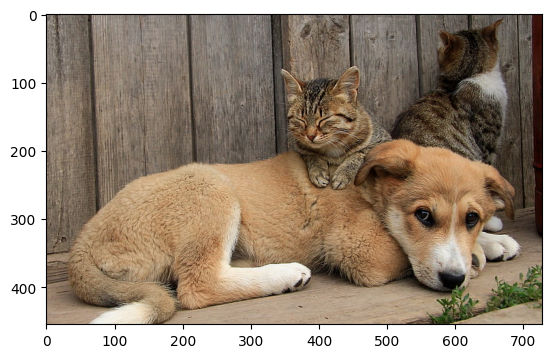

Transformed image size:  torch.Size([1, 3, 224, 224])
Classification result: 281


In [8]:
# read and visualize an image
img = utils.read_img('../data_and_models/images/cat_and_dog.jpg')
plt.imshow(img)
plt.show()

# next transform it so it is ready to be given to the model
trans_img = utils.transform_img(img, mean, std)
print('Transformed image size: ', trans_img.size())

# forward pass
out = gcmodel(trans_img) # img)
pred = out.argmax(dim=1)

print('Classification result:', pred.item())

What is the model predicting? Let's look at the top two predictions and try and understand each!

In [9]:
pred_sort= torch.argsort(out, descending=True)
top_ten = pred_sort[0,:10]
print('Top ten probabilities: ', top_ten)

Top ten probabilities:  tensor([281, 285, 282, 264, 263, 193, 273, 287, 231, 852])


Take a moment to identify the class names [ImageNet class list](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

Now let's use GradCAM to try and understand where the model is focusing for specific probabilities

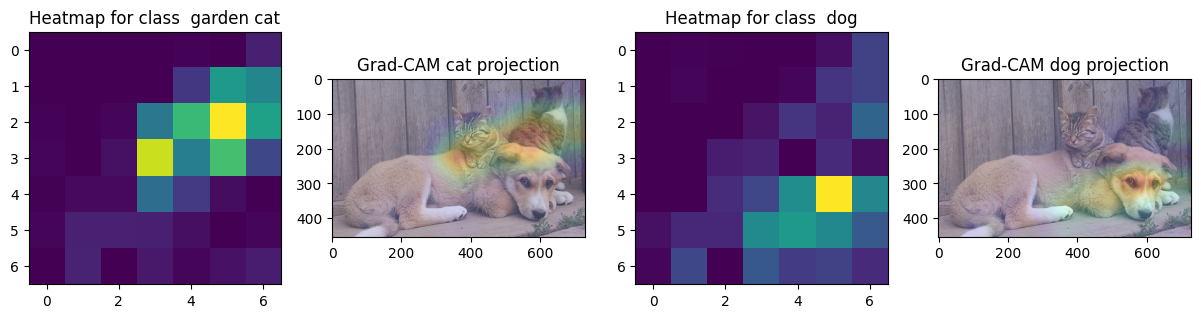

In [10]:
heatmap_cat = calculate_localization_map(gcmodel, trans_img, out, c=282)
heatmap_dog = calculate_localization_map(gcmodel, trans_img, out, c=231)

heatmap_catn = convert_to_heatmap(heatmap_cat, img)
heatmap_dogn = convert_to_heatmap(heatmap_dog, img)

plt.figure(figsize=(15, 15))
plt.subplot(141)
plt.imshow(heatmap_cat.squeeze())
plt.title('Heatmap for class  garden cat')
plt.subplot(142)
plt.imshow(heatmap_catn, cmap='jet', alpha=0.4)
plt.imshow(img, alpha=0.6)
plt.title('Grad-CAM cat projection')
plt.subplot(143)
plt.imshow(heatmap_dog.squeeze())
plt.title('Heatmap for class  dog')
plt.subplot(144)
plt.imshow(heatmap_dogn, cmap='jet', alpha=0.4)
plt.imshow(img, alpha=0.6)
plt.title('Grad-CAM dog projection')
plt.show()

---
Congratulations! You completed this tutorial.

<font color='green'>

#### Questionnaire: What did we learn today?

Look at [this short questionnaire](https://docs.google.com/presentation/d/1vd_HfkBD4FokoAM2el4T1rXWnD7_0FAEvxk4HgiYjXs/present?slide=id.g1499f1249e3_0_0) to revise what you have learned in our session so far! Think about the answers and discuss them with your group.

<font color='grey'>
    
#### Your Answer: 
1) 
2) 
3) 
4) 
5) 

<font color='green'>

#### Question 1: What do you think are the strengths and weaknesses of Grad-CAM on image classification?

<font color='grey'>

#### Your Answer: 


## Homework

* Look at the top-10 classes of the model - can you see a pattern?
* Can you implement the occlusion technique, see [here](https://towardsdatascience.com/inshort-occlusion-analysis-for-explaining-dnns-d0ad3af9aeb6), by removing the areas of the dog and cat on the last image and see what you get?

## Further reading:

Here is the original [GradCAM paper](https://arxiv.org/pdf/1610.02391.pdf)

This tutorial was based on: https://medium.com/@stepanulyanin/grad-cam-for-resnet152-network-784a1d65f3